<a href="https://colab.research.google.com/github/fadeevie/gan/blob/main/%D0%A4%D0%B0%D0%B4%D0%B5%D0%B5%D0%B2%D0%98%D0%95_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Введение*

В этой лабораторной работе мы будем работать с генерирующей состязательной сетью (GAN), которая является мощным инструментом для генерации изображений, текстов и других типов данных. GAN состоят из двух нейронных сетей: генератора и дискриминатора. Генератор пытается создать новые объекты, которые похожи на обучающие примеры, а дискриминатор пытается отличить реальные примеры от фальшивых.

В этой лабораторной работе мы будем работать с набором данных MNIST, который состоит из 6200 ч/б изображений размером 28x28 пикселя. Мы будем использовать генеративную модель для создания изображений, которые похожи на изображения из набора данных MNIST.

Цель работы

Целью данной лабораторной работы является изучение принципов работы генерирующих состязательных сетей (GAN) и применение их для создания изображений.

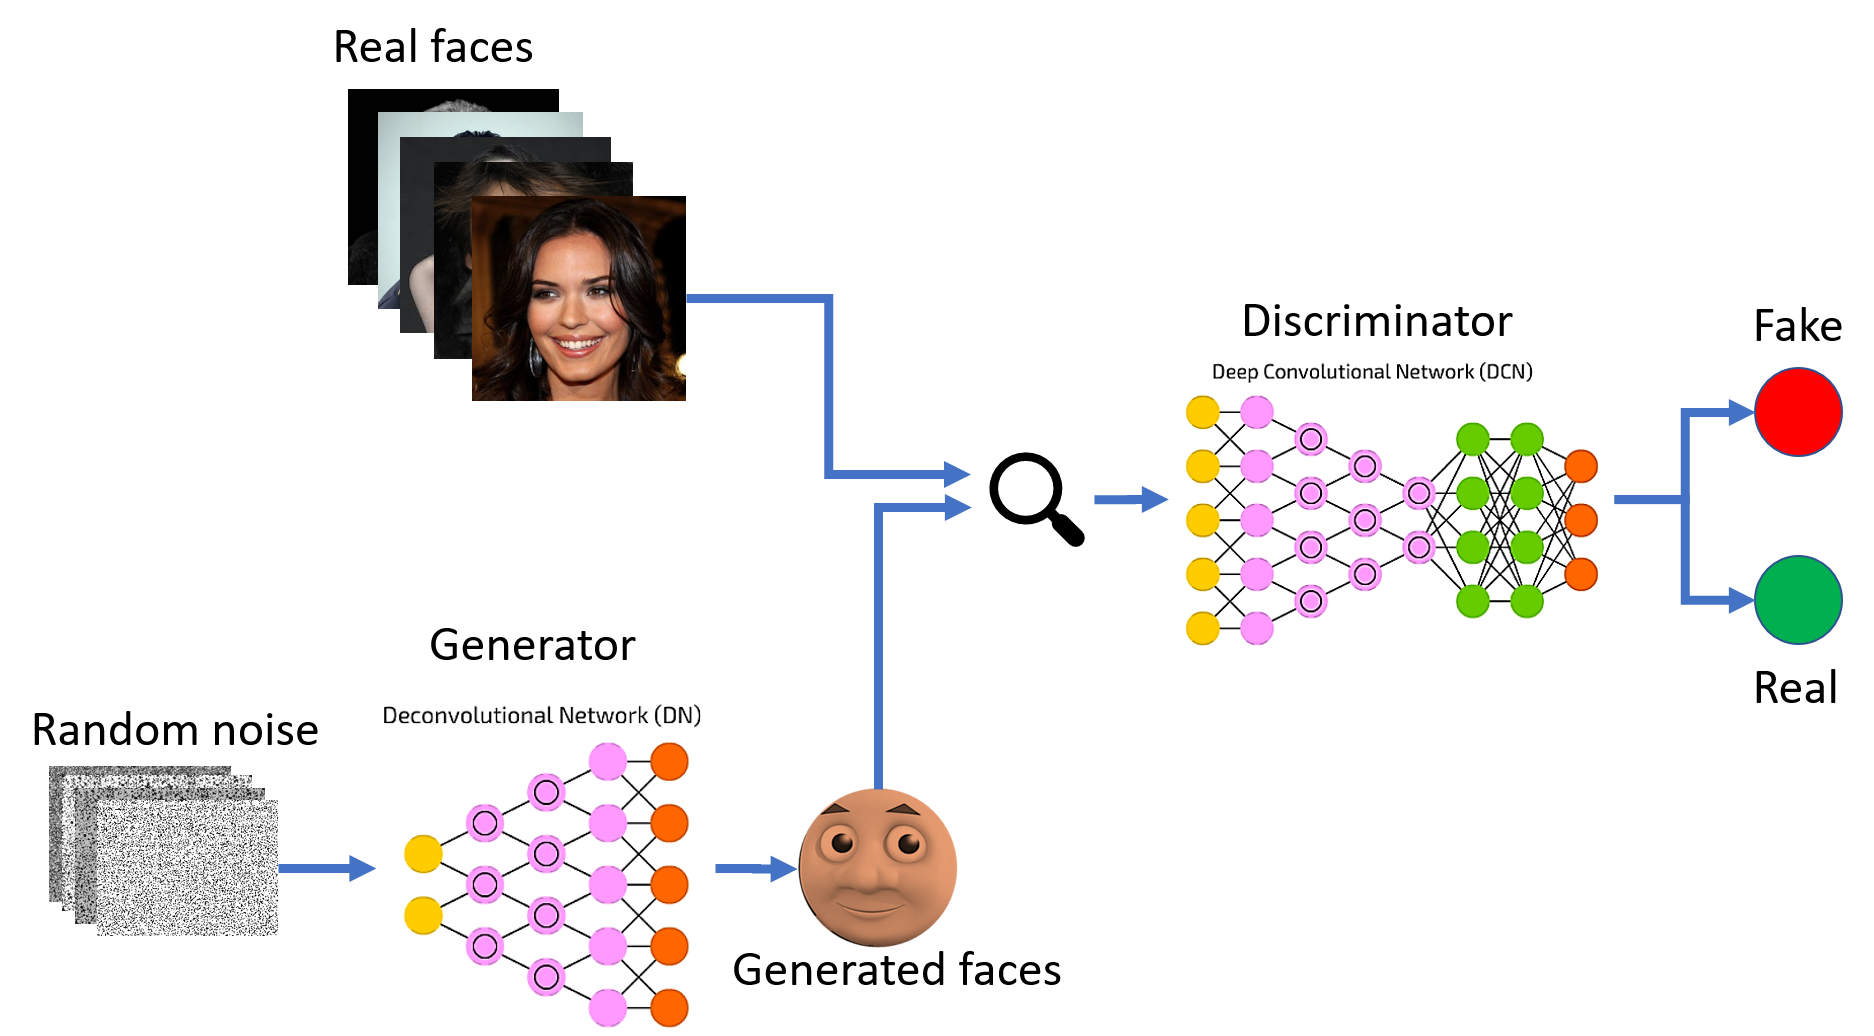

*Импорт библиотек*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import mnist
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

*Загрузка данных*

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[y_train==7]
y_train = y_train[y_train==7]

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

In [ ]:
BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(x_train.shape, y_train.shape)

(6200, 28, 28) (6200,)


In [ ]:
x_train = x_train / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# формирование сетей
hidden_dim = 2

def dropout_and_batch():
  return Dropout(0.3)(BatchNormalization())

*Создание генератора*

Теперь мы создадим генератор, который будет принимать на вход случайный шум и генерировать изображения.

In [ ]:
# генератор
generator = tf.keras.Sequential([
  Dense(7*7*256, activation='relu', input_shape=(hidden_dim,)),
  BatchNormalization(),
  Reshape((7, 7, 256)),
  Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])

*Создание дискриминатора*

Теперь мы создадим дискриминатор, который будет принимать на вход изображение и выводить вероятность того, что оно является реальным.

In [ ]:
discriminator = tf.keras.Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Flatten(),
    Dense(1)
])

*Функция потерь* для генератора и дискриминатора

In [ ]:
# потери
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

*Оптимизатор* для генератора и дискриминатора

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

*Функции для обучения*

In [ ]:
# обучение
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, hidden_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE // (BATCH_SIZE*MAX_PRINT_LABEL)

  for epoch in range(1, epochs+1):
    print(f'{epoch}/{EPOCHS}: ', end='')

    start = time.time()
    n = 0

    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      if( n % th == 0): print('=', end='')
      n += 1

    history += [gen_loss_epoch/n]
    print(': '+str(history[-1]))
    print ('Время эпохи {} составляет {} секунд'.format(epoch + 1, time.time()-start))

  return history

Запуск процесса обучения

1/20: ===========: tf.Tensor(1.5689775, shape=(), dtype=float32)
Время эпохи 2 составляет 74.35633373260498 секунд
2/20: ===========: tf.Tensor(2.6540418, shape=(), dtype=float32)
Время эпохи 3 составляет 68.79840660095215 секунд
3/20: ===========: tf.Tensor(3.3416326, shape=(), dtype=float32)
Время эпохи 4 составляет 67.66241908073425 секунд
4/20: ===========: tf.Tensor(3.4857183, shape=(), dtype=float32)
Время эпохи 5 составляет 77.72337031364441 секунд
5/20: ===========: tf.Tensor(3.3411002, shape=(), dtype=float32)
Время эпохи 6 составляет 77.51664471626282 секунд
6/20: ===========: tf.Tensor(3.5902455, shape=(), dtype=float32)
Время эпохи 7 составляет 70.50388383865356 секунд
7/20: ===========: tf.Tensor(3.054649, shape=(), dtype=float32)
Время эпохи 8 составляет 77.0528335571289 секунд
8/20: ===========: tf.Tensor(2.3998344, shape=(), dtype=float32)
Время эпохи 9 составляет 76.53214025497437 секунд
9/20: ===========: tf.Tensor(1.6175508, shape=(), dtype=float32)
Время эпохи 10 со

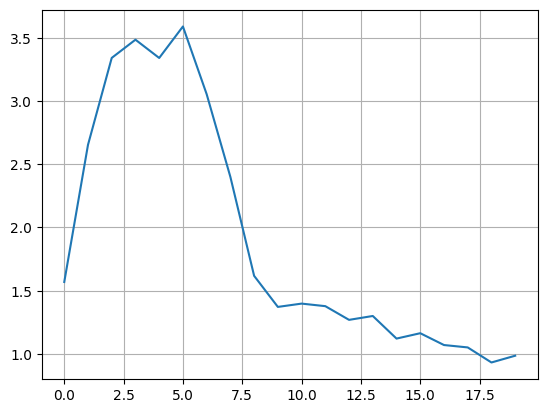

In [ ]:
# запуск процесса обучения
EPOCHS = 20
history = train(train_dataset, EPOCHS)

plt.plot(history)
plt.grid(True)

1/1 [==============================] - 0s 24ms/step


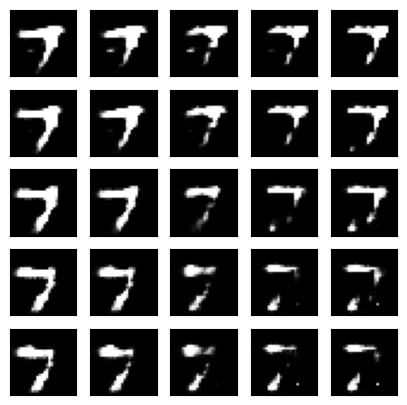

In [ ]:
# отображение результатов генерации
n = 2
total = 2*n+1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5*i/n, 0.5*j/n], axis=0))
    plt.imshow(img[0,:,:,0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)